# GFDL FLOR Historical

- Loads in all monthly forecasts of sea ice extent
- Regrids to polar stereographic,
- Saves to netcdf files grouped by year

In [1]:
'''

This code is part of the SIPN2 project focused on improving sub-seasonal to seasonal predictions of Arctic Sea Ice. 
If you use this code for a publication or presentation, please cite the reference in the README.md on the
main page (https://github.com/NicWayand/ESIO). 

Questions or comments should be addressed to nicway@uw.edu

Copyright (c) 2018 Nic Wayand

GNU General Public License v3.0


'''

# Standard Imports
%matplotlib inline
%load_ext autoreload
%autoreload
import matplotlib
import scipy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
import os
import glob
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# ESIO Imports
from esio import import_data


In [2]:
# General plotting settings
sns.set_style('whitegrid')
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [3]:
# Directories
model='gfdlsipn'
runType='reforecast'
base_dir = r'/home/disk/sipn/nicway/data/'
data_dir = os.path.join(base_dir, 'model', model, runType, 'native')
data_out = os.path.join(base_dir, 'model', model, runType, 'sipn_nc')
model_grid_file = os.path.join(base_dir, 'grids', 'GFDLFLOR_gridinfo.nc' )
stero_grid_file = os.path.join(base_dir, 'grids', 'stereo_gridinfo.nc')

In [4]:
gfdl_grid = import_data.load_grid_info(model_grid_file, model='GFDL')
gfdl_grid.dims

Frozen(SortedKeysDict({'nj': 200, 'ni': 360, 'nj_b': 201, 'ni_b': 361}))

In [5]:
# from dateutil.relativedelta import relativedelta
# init_time = np.datetime64('2012-01-01')
# fore_time = pd.timedelta_range(start=0, end=12, freq='MS')

In [6]:
# # Plot the input Grid
# %matplotlib notebook
# plt.figure(figsize=(10,8));
# ax1 = plt.axes(projection=ccrs.PlateCarree())
# ax1.scatter(gfdl_grid['lon_b'], gfdl_grid['lat_b'], s=6, c='r', transform=ccrs.PlateCarree())  # plot grid locations
# ax1.scatter(gfdl_grid['lon'], gfdl_grid['lat'], s=3, c='b', transform=ccrs.PlateCarree())  # plot grid locations
# plt.xlabel('lon')
# plt.ylabel('lat')

In [7]:
# # Plot the input Grid
# %matplotlib notebook
# plt.figure(figsize=(10,8));
# ax1 = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=0))
# ax1.scatter(gfdl_grid['lon_b'], gfdl_grid['lat_b'], s=6, c='r', transform=ccrs.PlateCarree())  # plot grid locations
# ax1.scatter(gfdl_grid['lon'], gfdl_grid['lat'], s=3, c='b', transform=ccrs.PlateCarree())  # plot grid locations
# plt.xlabel('lon')
# plt.ylabel('lat')

In [8]:
obs_grid = import_data.load_grid_info(stero_grid_file, model='NSIDC')
# Ensure latitude is within bounds (-90 to 90)
# Have to do this because grid file has 90.000001
obs_grid['lat_b'] = obs_grid.lat_b.where(obs_grid.lat_b < 90, other = 90)

In [9]:
# Regridding Options
method='conservative' # ['bilinear', 'conservative', 'nearest_s2d', 'nearest_d2s', 'patch']

In [10]:
cvar = 'sic'

In [11]:
xr.set_options(enable_cftimeindex=True)

In [12]:
weights_flag = False # Flag to set up weights have been created

for year in np.arange(1980, 2014, 1):
# for year in np.arange(1980, 1981, 1):
    
    # Loop over each ensemble member
    ds_list = []
    for e in np.arange(1,13,1):
        ensm_name = 'r'+str(e)+'i1p1'
        cfiles = os.path.join(data_dir, '*'+cvar+'*'+ensm_name+'_'+str(year)+'*.nc')
        ds_list.append(import_data.open_1_member_monthly(cfiles, e))
    ds_all = xr.concat(ds_list, dim='ensemble')

    # Fix GFDL grid
    # Files comes with incorrect lat/lon at poles. Use correct separate file to update coords
    ds_all.rename({'lat':'nj', 'lon':'ni'}, inplace=True); # Rename wrong-lat/lon to indices
    ds_all.coords['nj'] = gfdl_grid.nj
    ds_all.coords['ni'] = gfdl_grid.ni
    ds_all.coords['lat'] = gfdl_grid.lat
    ds_all.coords['lon'] = gfdl_grid.lon
    ds_all.coords['lat_b'] = gfdl_grid.lat_b
    ds_all.coords['lon_b'] = gfdl_grid.lon_b
    
    # Split up grid into "top" and "bottom"
    (ds_top, ds_bottom) = import_data.split_GFDL(ds_all, varnames=cvar)
    
    # Calculate regridding matrix
    regridder_top = xe.Regridder(ds_top, obs_grid, method, periodic=False, reuse_weights=weights_flag)
    regridder_bottom = xe.Regridder(ds_bottom, obs_grid, method, periodic=False, reuse_weights=weights_flag)
    weights_flag = True # Set true for following loops
    
    # Add NaNs to empty rows of matrix (forces any target cell with ANY source cells containing NaN to be NaN)
    regridder_top = import_data.add_matrix_NaNs(regridder_top)
    regridder_bottom = import_data.add_matrix_NaNs(regridder_bottom)
    
    # Average over all sea ice categories 
    if cvar=='sic':
        sic_top = ds_top.sic.sum(dim='ct', skipna=False)
        sic_bottom = ds_bottom.sic.sum(dim='ct', skipna=False)
    else:
        raise ValueError("Only sic implemented...")
        
    # Regrid
    sic_out_top = regridder_top(sic_top)
    sic_out_bottom = regridder_bottom(sic_bottom)
    
    # Mask by latitude
    lat_split = ds_all.lat.isel(nj=175).min() # Get the latitude where model domain was split on
    lat_split_2 = ds_all.lat.isel(nj=175+5).max() #
    sic_out_top = sic_out_top.where( (sic_out_top.lat>=lat_split).values )
    sic_out_bottom = sic_out_bottom.where( (sic_out_bottom.lat<lat_split_2).values )
 
    # Add dropped coords
    sic_out_top['fore_time'] = ds_all.fore_time
    sic_out_bottom['fore_time'] = ds_all.fore_time
    
    # Merge "top" and "bottom"
    sic_all = sic_out_top.combine_first(sic_out_bottom)

    # # Save regridded to netcdf file
    f_out = os.path.join(data_out, 'GFDL_FLORB01_'+str(year)+'_Stereo.nc')
    sic_all.to_netcdf(f_out)
    sic_all = None # Memory clean up
    print('Saved ', f_out)

Overwrite existing file: conservative_50x180_304x448.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: conservative_185x360_304x448.nc 
 You can set reuse_weights=True to save computing time.


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/scipy/sparse/compressed.py:742: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


Saved  /home/disk/sipn/nicway/data/model/gfdlsipn/reforecast/sipn_nc/GFDL_FLORB01_1980_Stereo.nc
Reuse existing file: conservative_50x180_304x448.nc
Reuse existing file: conservative_185x360_304x448.nc


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/scipy/sparse/compressed.py:742: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


Saved  /home/disk/sipn/nicway/data/model/gfdlsipn/reforecast/sipn_nc/GFDL_FLORB01_1981_Stereo.nc
Reuse existing file: conservative_50x180_304x448.nc
Reuse existing file: conservative_185x360_304x448.nc
Saved  /home/disk/sipn/nicway/data/model/gfdlsipn/reforecast/sipn_nc/GFDL_FLORB01_1982_Stereo.nc
Reuse existing file: conservative_50x180_304x448.nc
Reuse existing file: conservative_185x360_304x448.nc
Saved  /home/disk/sipn/nicway/data/model/gfdlsipn/reforecast/sipn_nc/GFDL_FLORB01_1983_Stereo.nc
Reuse existing file: conservative_50x180_304x448.nc
Reuse existing file: conservative_185x360_304x448.nc
Saved  /home/disk/sipn/nicway/data/model/gfdlsipn/reforecast/sipn_nc/GFDL_FLORB01_1984_Stereo.nc
Reuse existing file: conservative_50x180_304x448.nc
Reuse existing file: conservative_185x360_304x448.nc
Saved  /home/disk/sipn/nicway/data/model/gfdlsipn/reforecast/sipn_nc/GFDL_FLORB01_1985_Stereo.nc
Reuse existing file: conservative_50x180_304x448.nc
Reuse existing file: conservative_185x360_3

In [13]:
sic_all

In [14]:
# Clean up
regridder_top.clean_weight_file()  # clean-up
regridder_bottom.clean_weight_file()  # clean-up

Remove file conservative_50x180_304x448.nc
Remove file conservative_185x360_304x448.nc


# Plotting

In [15]:
sic_all

In [19]:
sic_all = xr.open_dataset(f_out).sic

In [20]:
# Set up plotting info
cmap_sic = matplotlib.colors.ListedColormap(sns.color_palette("Blues", 10))
cmap_sic.set_bad(color = 'red')

Text(0.5,1,'Target Grid')

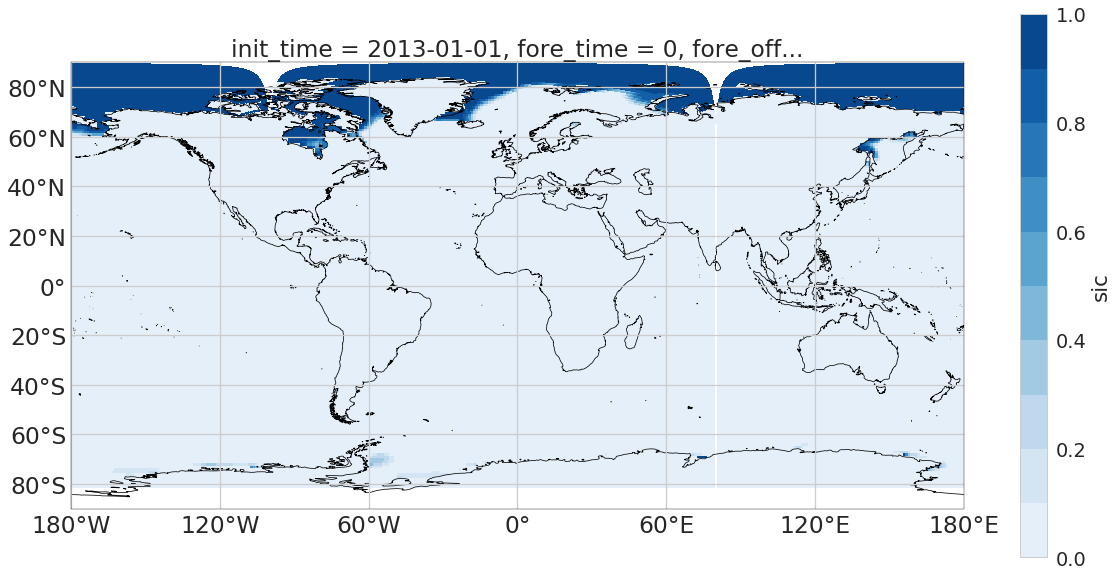

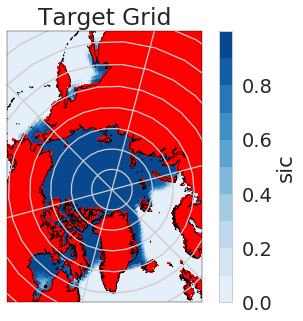

In [21]:
# Plot original projection
plt.figure(figsize=(20,10))
ax1 = plt.axes(projection=ccrs.PlateCarree())
ds_p = ds_all.sic.isel(init_time=0).isel(fore_time=0).isel(ensemble=0).sum(dim='ct')
ds_p.plot.pcolormesh(ax=ax1, x='lon', y='lat', 
                                 vmin=0, vmax=1,
                                 cmap=matplotlib.colors.ListedColormap(sns.color_palette("Blues", 10)),
                    transform=ccrs.PlateCarree());
ax1.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
gl = ax1.gridlines(crs=ccrs.PlateCarree(), linestyle='-')
gl.xlabels_bottom = True
gl.ylabels_left = True
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax1.coastlines(linewidth=0.75, color='black', resolution='50m');

# Plot SIC on target projection
(f, ax1) = ice_plot.polar_axis()
ds_p2 = sic_all.isel(init_time=0).isel(fore_time=0).isel(ensemble=0)
ds_p2.plot.pcolormesh(ax=ax1, x='lon', y='lat', 
                                     transform=ccrs.PlateCarree(),
                                     cmap=cmap_sic)
ax1.set_title('Target Grid')


In [ ]:
# %matplotlib inline

# ax1 = ice_plot.polar_axis()
# sic_top.isel(init_time=0).isel(fore_time_i=6).isel(ensemble=0).plot.pcolormesh(ax=ax1, x='lon', y='lat', 
#                                      transform=ccrs.PlateCarree(),
#                                      cmap=cmap_sic)
# ax1.set_title('sic_top')



# ax1 = ice_plot.polar_axis()
# sic_bottom.isel(init_time=0).isel(fore_time_i=6).isel(ensemble=0).plot.pcolormesh(ax=ax1, x='lon', y='lat', 
#                                      transform=ccrs.PlateCarree(),
#                                      cmap=cmap_sic)
# ax1.set_title('sic_bottom')

# ax1 = ice_plot.polar_axis()
# sic_out_top.isel(init_time=1).isel(fore_time_i=6).isel(ensemble=0).plot.pcolormesh(ax=ax1, x='lon', y='lat', 
#                                      transform=ccrs.PlateCarree(),
#                                      cmap=cmap_sic)
# ax1.set_title('sic_out_top')



# ax1 = ice_plot.polar_axis()
# sic_out_bottom.isel(init_time=1).isel(fore_time_i=6).isel(ensemble=0).plot.pcolormesh(ax=ax1, x='lon', y='lat', 
#                                      transform=ccrs.PlateCarree(),
#                                      cmap=cmap_sic)
# ax1.set_title('sic_out_bottom')


# # Plot SIC on target projection
# ax1 = ice_plot.polar_axis()
# ds_p2 = sic_all.isel(init_time=0).isel(fore_time_i=6).isel(ensemble=0)
# ds_p2.plot.pcolormesh(ax=ax1, x='lon', y='lat', 
#                                      transform=ccrs.PlateCarree(),
#                                      cmap=cmap_sic)
# ax1.set_title('Combined final')
